### Use a trained random forest model to predict missing values
#### First we optionally change some known values to NaN. Later we compare the original values to predicted values

In [2]:
#All the imports
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Read the YSO classification file for YSOs from Gutermuth et al. 2009 (G09)
# Table 4 in G09, full data available online
# I have downloaded a TSV file from VizieR, and replaced blanks by NaNs before using here.

df_yso = pd.read_csv("table4_Gutermuth09.csv", comment='#', header=0)

print(df_yso.shape)
df_yso.head()

(2548, 11)


,Jmag,Hmag,Ksmag,3.6mag,4.5mag,5.8mag,8.0mag,24mag,AKs,alpha,Cl
0,15.1,14.3,13.92,13.27,NaN,12.34,NaN,6.82,0.10,NaN,I*
1,NaN,NaN,13.84,11.34,10.05,8.99,8.10,4.34,NaN,0.87,I
2,NaN,NaN,14.98,11.90,10.76,9.96,9.28,NaN,NaN,0.12,I
3,NaN,15.0,12.86,10.52,9.61,8.84,7.97,NaN,1.92,0.08,I
4,NaN,NaN,NaN,14.22,13.20,12.09,11.36,NaN,NaN,0.48,I


In [4]:
# Get information of the dataframe
df_yso.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2548 entries, 0 to 2547
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Jmag    1675 non-null   float64
 1   Hmag    1970 non-null   float64
 2   Ksmag   2132 non-null   float64
 3   3.6mag  2523 non-null   float64
 4   4.5mag  2522 non-null   float64
 5   5.8mag  2381 non-null   float64
 6   8.0mag  2203 non-null   float64
 7   24mag   1274 non-null   float64
 8   AKs     1937 non-null   float64
 9   alpha   2171 non-null   float64
 10  Cl      2548 non-null   object 
dtypes: float64(10), object(1)
memory usage: 219.1+ KB


In [5]:
# Drop the dataset containing NaN values
df_yso = df_yso.copy()
df_yso.dropna(inplace=True)
df_yso.head()

,Jmag,Hmag,Ksmag,3.6mag,4.5mag,5.8mag,8.0mag,24mag,AKs,alpha,Cl
8,13.59,12.48,12.05,11.96,11.03,10.09,9.02,5.41,0.53,0.54,I
10,16.16,14.00,12.56,10.33,9.41,8.58,7.67,4.13,1.27,0.21,I
13,13.18,11.59,10.68,9.62,9.26,8.93,8.47,6.27,0.86,-1.53,II
15,14.95,13.76,13.03,12.01,11.44,10.87,9.98,6.64,0.38,-0.51,II
19,13.07,11.91,11.22,10.29,9.85,9.46,8.89,6.47,0.39,-1.24,II


In [6]:
# check if any value in above df is a NaN
df_yso.isnull().values.any()

False

In [7]:
# make a new dataframe, with only flux_cols
flux_cols = ["Jmag", "Hmag", "Ksmag", "3.6mag", "4.5mag", "5.8mag", "8.0mag", "24mag"]

df_test = df_yso[flux_cols]
df_test.head()

,Jmag,Hmag,Ksmag,3.6mag,4.5mag,5.8mag,8.0mag,24mag
8,13.59,12.48,12.05,11.96,11.03,10.09,9.02,5.41
10,16.16,14.00,12.56,10.33,9.41,8.58,7.67,4.13
13,13.18,11.59,10.68,9.62,9.26,8.93,8.47,6.27
15,14.95,13.76,13.03,12.01,11.44,10.87,9.98,6.64
19,13.07,11.91,11.22,10.29,9.85,9.46,8.89,6.47


#### We test prediction on df_test.
#### Strategy-
1. Randomly replace a certain percent of DF by NaNs. 
2. Use generalized RF to predict NaNs. 
3. Compare true values to predicted values and plot the error as a function of percentage of missing data

In [10]:
# Initialize seed
random.seed(0)

# what percent of data should have NaN
nan_percent = np.arange(0.01, 0.98, 0.05)

# Make and predict NaN values using learned RF model

# Randomly replace certain datasets by NaN 
MSE, MPE = [], [] # Mean squared error, mean percentage error
for percent in nan_percent:
    df_test1 = df_test.copy()
    indices_all = [(row, col) for row in range(df_test1.shape[0]) for col in range(df_test1.shape[1])]
    row_nan, col_nan = [], []
    for row, col in random.sample(indices_all, int(round(percent*len(indices_all)))):
        row_nan.append(row)
        col_nan.append(col)
        df_test1.iat[row, col] = np.nan


    # predict missing values using a trained RF model
    imputer = SimpleImputer()
    df_test2 = imputer.fit(df_test1).transform(df_test1.copy())
    df_test2 = pd.DataFrame(df_test2, columns=flux_cols)

    # Check imputed values
    target, prediction = [], []
    for i in zip(row_nan, col_nan):
        target.append(df_test.iat[i])
        prediction.append(df_test2.iat[i])

    target = np.array(target)
    prediction = np.array(prediction)

    # Calculate the mean squared error, and also mean percentage error
    MSE.append(mean_squared_error(target, prediction))
    MPE.append(np.mean(abs(target - prediction) / target * 100.))

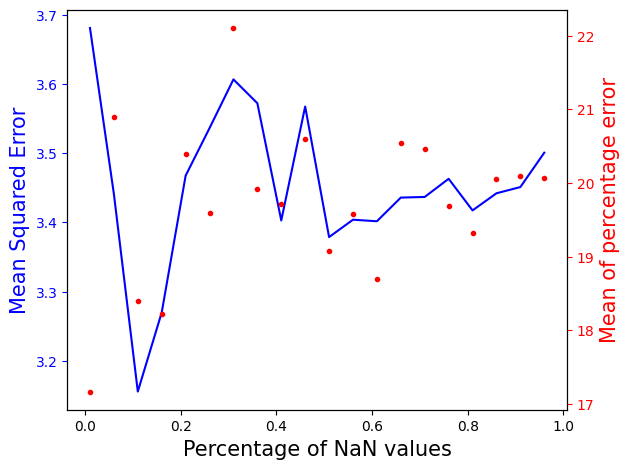

In [11]:
# Plot the error estimates (both MSE and percent difference) with percentage of data that were masked as NaN

fig, ax1 = plt.subplots()
# t = np.arange(0.01, 10.0, 0.01)
# s1 = np.exp(t)
ax1.plot(nan_percent, MSE, 'b-')
ax1.set_xlabel("Percentage of NaN values", fontsize=15)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel("Mean Squared Error", fontsize=15, color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
# s2 = np.sin(2 * np.pi * t)
ax2.plot(nan_percent, MPE, 'r.')
ax2.set_ylabel("Mean of percentage error", fontsize=15, color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

#### If 10% of data is missing, using a trained random forest model we can predict such missing data to within ~5%.